In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#conda install matplotlib --y


In [1]:
"""
- Artificial Neural Network with 1 hidden Layer
- Cost Function : SSE
- Activation Function : tanh

- Data : generated noisy sinc function


Author : Dr Kamel Saadi
Date   : 12/12/2017

incorporating bias for each node
most likely to enable bias only in the output node.

As we have seen in previous examples, if we don't use bias term
the sinc function nnet learning won't work
"""

import numpy as np
#---------------------- Classes --------------------------------------  

class layer:
    def __init__(self, activ, n_nodes, n_inputs,  biasFlag = True):
        self.n_nodes  = n_nodes
        self.n_inputs = n_inputs
        self.activ    = activ
        self.biasVal  = float(biasFlag) # this is to use later in the training
        self.acfunc, self.deriv_out = self.__generate_funcs() 
        self.w = 2*np.random.random([n_nodes, n_inputs+1])-1
        if not activ in ['linear','sigmoid','tanh']:
            print("Allowed activation function : linear,sigmoid,tanh")
        # self.biasVa if no use of bias it is set to 0
        # the last value in the weight represent the bias
        if not biasFlag: self.w[:,-1] = 0.0                                       
    
    def feed(self,x):
        d = np.dot(self.w, np.hstack((x,1.0)))
        return  self.acfunc(d)
    
    def feedData(self,X):        
        one = np.ones([X.shape[0],1])        
        d   = np.dot(np.hstack((X,one)),self.w.T)
        return self.acfunc(d) 
   
    def __generate_funcs(self):
        if self.activ=='linear':
            def tmp(x):return x   
            def tmp1p(y):return 1.0       
        elif self.activ=='sigmoid':
            def tmp(x): return 1.0/(1.0+np.exp(-x))
            def tmp1p(y): return y*(1-y)                        
        elif self.activ=='tanh':
            def tmp(x): return np.tanh(x)
            def tmp1p(y): return (1-y*y)            
        else: pass
        return tmp, tmp1p    
    
    def bias(self):
        return self.w[:,-1]  
    

class output_layer(layer):
    def __init__(self, cost, activ, n_nodes, n_inputs, biasFlag ):
        layer.__init__(self,activ, n_nodes, n_inputs, biasFlag)
        self.costType = cost
        if not cost in ['sse','entropy']:
            print("Allowed error cost functions : 'sse','entropy'") 
        #  costFunc is the error function (y-f)^2
        #  costFuncDeriv is derivative of the cost function w.r.t f 
        #  for example 2(y-f)(-1)
        #  y is the target and f is the predicted value
        self.costFunc, self.costFuncDeriv = self.__costFunction()            
            
    def __costFunction(self):
        if self.costType=='sse':
            def tmp(y,f):return (y-f)**2
            def tmp1p(y,f) : return 2*(f-y)
        elif self.costType=='entropy':
            def tmp(y,f): return -(y*np.log(f)+(1-y)*np.log(1-f)) 
            def tmp1p(y,f): return -(y/f - (1-y)/(1-f))      
        else: pass
        return tmp, tmp1p
 
    def score(self,x, prevLayer):
        # default is one hidden layer
        o1 = prevLayer.feedData(x)
        o2 = self.feedData(o1)
        return o2
    
    def score2(self,x, Layer2,Layer1 ):
        # NNET with 3 layers (2 hidden) current is L3
        o1 = L1.feedData(x)
        o2 = L2.feedData(o1)
        o3 = self.feedData(o2)
        return o3
        

In [2]:
np.random.seed(345)
XI = np.linspace(-10,10,500).reshape(-1,1)
n = XI.shape[0]
ytrue = np.sin(XI)/XI
YI = ytrue + 0.2*np.random.randn(n).reshape(n,1)  


import random 

n_tr = int(0.5*n)  # split 50/50

tr_ix = random.sample(range(n),n_tr)
te_ix = list(set(range(n))-set(tr_ix))

Xtr, Ytr = XI[tr_ix,:], YI[tr_ix,:]
Xte, Yte = XI[te_ix,:], YI[te_ix,:]


In [3]:
np.random.seed(3148)     
#np.random.seed(45)
n_nodes = 30             
in_dim = XI.shape[1]

#--------------------------------------------------------------------------

#np.random.seed(3148) good combo
#n_nodes = 30 
#L1    = layer('tanh',n_nodes ,in_dim, True) # no bias
#L2    = output_layer('sse','tanh',1, n_nodes, True) # bias 


n_nodes = 60
L1    = layer('tanh',n_nodes ,in_dim, True) # it is important that we have the bias here
# linear for L2 converge faster, tanh fits a bit better but take longer.
L2    = output_layer('sse','linear',1, n_nodes, True) #  

eta = 0.001

iters, sErr = 1000, np.Infinity
TrEnt       = []
TeEnt       = []
for i in range(iters):          
    #np.random.shuffle(X)
    for obs in range(Xtr.shape[0]):
        o0 , y = Xtr[obs,:], float(Ytr[obs])
        o1 = L1.feed(o0)
        o2 = float(L2.feed(o1))
       
        dCost_do2 = L2.costFuncDeriv(y,o2)
        
        delta2 = dCost_do2*L2.deriv_out(o2)   
        # here eta*delta applies to the last column of
        # the resulting hstack, i.e. the bias
        L2.w  += -eta*delta2*np.hstack((o1, L2.biasVal ))
            
        delta1 = delta2*L1.deriv_out(o1)            
        L1.w  += -eta*delta1.reshape(-1,1)*np.hstack((o0, L1.biasVal ))
        
    _tr = L2.costFunc(Ytr,L2.score(Xtr,L1))
    _te = L2.costFunc(Yte,L2.score(Xte,L1))
    
    train_err = float(sum(_tr))
    test_err  = float(sum(_te))
    sErr0     = sErr    
    sErr      = test_err  
    if (sErr-sErr0)/sErr0>1e-6 and i>50: 
       break    
    print("epoch = ",i," Validation =",round(sErr,4)," Training =", 
                                                   round(train_err,4) )
    TrEnt.append(train_err)    
    TeEnt.append(test_err)   


epoch =  0  Validation = 41.9755  Training = 40.7813
epoch =  1  Validation = 19.6548  Training = 20.0381
epoch =  2  Validation = 17.8472  Training = 17.8668
epoch =  3  Validation = 17.2861  Training = 17.2878
epoch =  4  Validation = 17.1528  Training = 17.1212
epoch =  5  Validation = 17.136  Training = 16.7902
epoch =  6  Validation = 16.7169  Training = 15.8487
epoch =  7  Validation = 15.7948  Training = 14.7581
epoch =  8  Validation = 14.8272  Training = 14.3275
epoch =  9  Validation = 14.2747  Training = 14.4057
epoch =  10  Validation = 13.8947  Training = 14.2645
epoch =  11  Validation = 13.737  Training = 14.1927
epoch =  12  Validation = 13.7289  Training = 14.2246
epoch =  13  Validation = 13.7677  Training = 14.2883
epoch =  14  Validation = 13.7955  Training = 14.3355
epoch =  15  Validation = 13.7867  Training = 14.3437
epoch =  16  Validation = 13.7358  Training = 14.3096
epoch =  17  Validation = 13.6546  Training = 14.2462
epoch =  18  Validation = 13.5633  Train

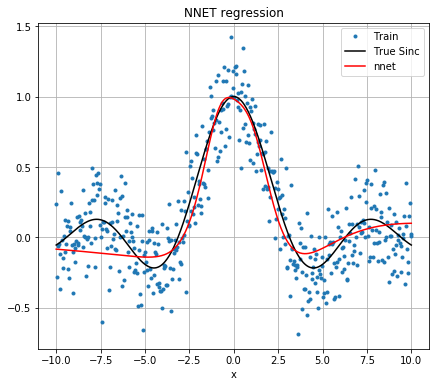

In [9]:
import  matplotlib.pyplot as plt

yhat = L2.score(XI,L1)

plt.figure(figsize=(7,6))
plt.plot(XI,YI,'.',label='Train')
plt.plot(XI,ytrue,'-k', label='True Sinc')
plt.plot(XI,yhat,'-r', label='nnet')
plt.xlabel('x')
plt.legend(loc='upper right')  
plt.title('NNET regression')
plt.grid()
plt.show()


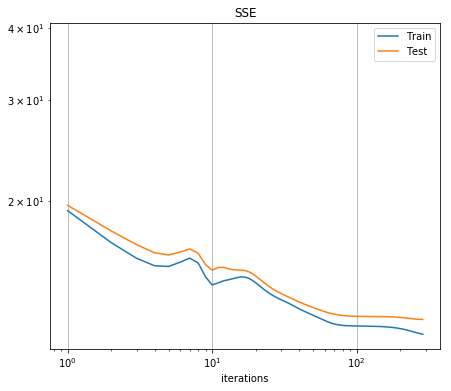

In [49]:
    
plt.figure(figsize=(7,6))
plt.loglog(TrEnt,label='Train')
plt.loglog(TeEnt, label='Test')
plt.xlabel('iterations')
plt.legend(loc='upper right') 
plt.title("SSE")
plt.grid()
plt.show()  

In [65]:
L2.bias()

array([-0.03722921])